# Metric Learning Homework

Author: **Dmytro Lopushanskyy**

This is Part 1 of the Metric Learning Homework. It contains two models:
* Plain pre-trained ImageNet backbone
* Fine-tuned with vanilla Cross-Entropy and classification approach

# Imports

In [1]:
import os
import yaml
import numpy as np
import pandas as pd
import json
import time
import random
import copy
import cv2
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import albumentations as albu
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from annoy import AnnoyIndex
from tqdm import tqdm

data_path = '/home/dmytro/metric-learning/Stanford_Online_Products/'
random.seed(5)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Load data

Unzip the archive into a local filesystem

In [2]:
# !unzip -q '/home/dmytro/metric-learning/Stanford_Online_Products.zip' -d '/home/dmytro/metric-learning/'

In [3]:
full_train_df = pd.read_csv(os.path.join(data_path, 'Ebay_train.txt'), sep=' ')
full_train_df.set_index('image_id')

,class_id,super_class_id,path
image_id,,,
1,1,1,bicycle_final/111085122871_0.JPG
2,1,1,bicycle_final/111085122871_1.JPG
3,1,1,bicycle_final/111085122871_2.JPG
4,1,1,bicycle_final/111085122871_3.JPG
5,1,1,bicycle_final/111085122871_4.JPG
...,...,...,...
59547,11318,12,toaster_final/221852410489_0.JPG
59548,11318,12,toaster_final/221852410489_1.JPG
59549,11318,12,toaster_final/221852410489_2.JPG


Testing dataframe below will be used for the final image retrieval testing

In [4]:
test_df = pd.read_csv(os.path.join(data_path, 'Ebay_test.txt'), sep=' ')
test_df.set_index('image_id')

,class_id,super_class_id,path
image_id,,,
59552,11319,1,bicycle_final/251952414262_0.JPG
59553,11319,1,bicycle_final/251952414262_1.JPG
59554,11319,1,bicycle_final/251952414262_2.JPG
59555,11319,1,bicycle_final/251952414262_3.JPG
59556,11319,1,bicycle_final/251952414262_4.JPG
...,...,...,...
120049,22633,12,toaster_final/400977584616_1.JPG
120050,22634,12,toaster_final/400977722713_0.JPG
120051,22634,12,toaster_final/400977722713_1.JPG


## Split the train dataset into train & validation

It's important that train/vaidation split is **stratified by class_id** so that later for evaluation we could retrieve same class_id from the training index.

In [5]:
train_df, valid_df = train_test_split(
    full_train_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=full_train_df[['class_id']]
)

In [6]:
train_df

,image_id,class_id,super_class_id,path
5237,5238,762,2,cabinet_final/131549715988_0.JPG
14875,14876,2484,3,chair_final/221591724921_2.JPG
18200,18201,3115,4,coffee_maker_final/151784132119_5.JPG
41995,41996,7527,9,sofa_final/111690092914_2.JPG
5994,5995,908,2,cabinet_final/151563594880_0.JPG
...,...,...,...,...
31606,31607,5546,7,lamp_final/151762188374_0.JPG
37152,37153,6585,8,mug_final/141740701326_1.JPG
56388,56389,10689,12,toaster_final/131575345407_4.JPG
35208,35209,6201,8,mug_final/111641075307_3.JPG


# Create custom dataset & dataloader

This class will help to keep different parts of code logic separate and follow PyTorch model training design.

### Important: this dataset class also performs data augmentation using albumentations library to prevent overfitting and generalize better.

In [7]:
class ProductsDataset(Dataset):    
    def __init__(self, df):
        # df should have these cols: class_id, super_class_id, path
        self.df = df
        self.img_size = (250, 250)
        
        # Data augmentation
        self.augmenter = albu.Compose([
            albu.HorizontalFlip(),
            albu.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.1, rotate_limit=10, p=0.4),
            albu.OneOf(
                [
                    albu.RandomBrightnessContrast(),
                    albu.RandomGamma(),
                    albu.MedianBlur(),
                ], 
                p=0.5
            ),
        ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        class_id = self.df.iloc[idx]['class_id']
        super_class_id = self.df.iloc[idx]['super_class_id']
        img_path = data_path + self.df.iloc[idx]['path']
        
        if type(img_path) == pd.Series:
            img_path = img_path.values[0]
        
        img = cv2.imread(f'{img_path}')
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_NEAREST)
        
        img = self.augmenter(image=img)['image']
        img = img.transpose((2, 0, 1))  # HWC -> CHW
        
        return np.float32(img / 255), class_id, super_class_id

In [8]:
train_dataset = ProductsDataset(train_df)
valid_dataset = ProductsDataset(valid_df)
test_dataset = ProductsDataset(test_df)

In [9]:
def visualize_img(idx, verbose=False):
    img, class_id, super_class_id = train_dataset[idx]

    if verbose:
        fig = plt.figure()
        rows, cols = 1, 1
        fig.add_subplot(rows, cols, 1)
    #     plt.imshow(transforms.ToPILImage()(img[0]), interpolation="nearest")
        plt.imshow(cv2.cvtColor(img.transpose((1, 2, 0)), cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title('Image')
        print(f'Class id: {class_id}\nSuper Class id: {super_class_id}\n')
    return img

Example of image visualization

Class id: 908
Super Class id: 2



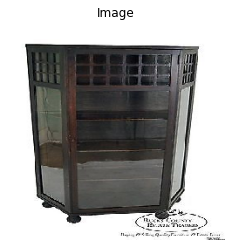

In [10]:
example = visualize_img(4, True)

# Task 1. Use plain pre-trained ImageNet backbone

In [11]:
# Load the pretrained model
resnet18 = models.resnet18(pretrained=True)

resnet18 = resnet18.to(device)

# Use the model object to select the desired layer
layer = resnet18._modules.get('avgpool')

# Set model to evaluation mode
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
def get_vector(model, image):
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data.reshape(o.data.size(1)))
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(torch.tensor(image).unsqueeze(0).to(device))
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

In [13]:
feature_v = get_vector(resnet18, example)

Output embedding is of size 512

In [14]:
feature_v.shape

torch.Size([512])

# Building an Index

Now that we have the model capable of producing embeddings, let's build an index on the embeddings of the training dataset. 

In [15]:
resnet_output_size = 512  # Length of item vector that will be indexed

def build_index(model, model_name):
    skipped = 0
    saved = 0
    t = AnnoyIndex(resnet_output_size, 'angular')
    for idx, data in enumerate(tqdm(train_dataset)):
        img, class_id, super_class_id = data[0], data[1], data[2]
        if img is None:
            skipped += 1
            continue
        feature_v = get_vector(resnet18, img)
        t.add_item(idx, feature_v)
        saved += 1
        
    print(f'Skipped {skipped} data points because of reading / transformation errors')
    print(f'Successfully saved {saved} data points in the index')

    t.build(12)  # 12 trees
    t.save(f'{model_name}-index.ann')
    
    return t


def load_index(idx_path):
    u = AnnoyIndex(resnet_output_size, 'angular')
    u.load('test.ann') # super fast, will just mmap the file
    return u

Below we build an index and perform a test retrival based on index

In [16]:
annoy_index = build_index(resnet18, 'base-resnet18')
annoy_index.get_nns_by_item(0, 5)

100%|█| 47640/47640 [05:24<00:00, 146.72it/


Skipped 0 data points because of reading / transformation errors
Successfully saved 47640 data points in the index


[0, 16107, 34529, 37310, 15668]

## Evaluation

I have implemented the accuracy and mAP5 metrics manually. The below slide helped me a lot to understand better how to do it [(link)](https://slideplayer.com/slide/2295316/)

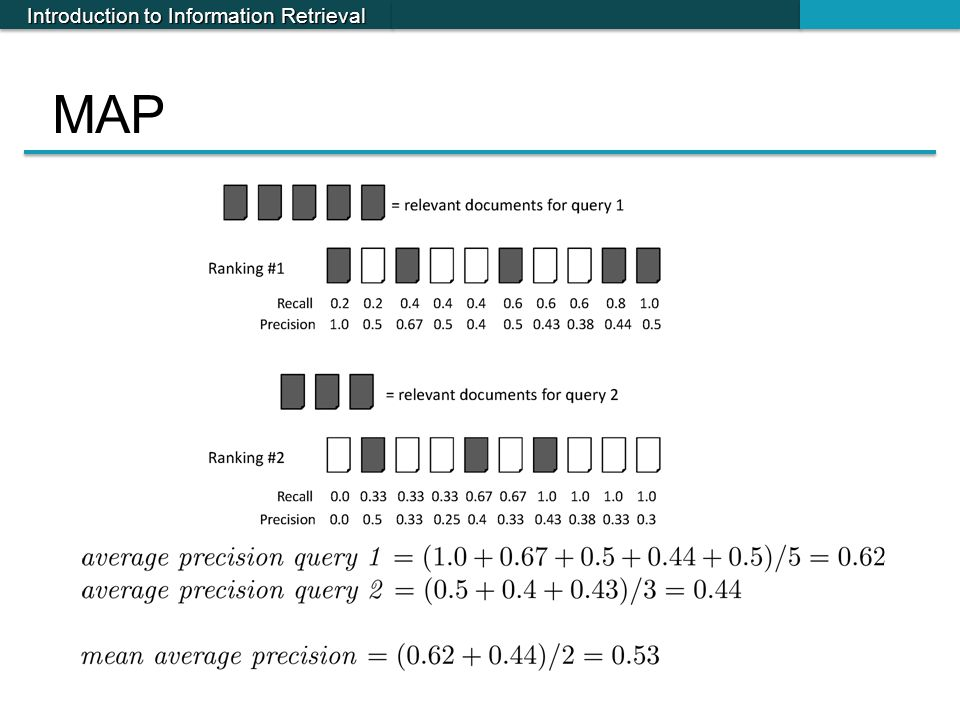

In [17]:
def evaluate(valid_dataset):
    # calculate ranked accuracy
    tp_class_id = 0
    tp_super_class_id = 0
    total = 0
    map_score_class_id = 0
    map_score_superclass_id = 0
    map_total = 0
    for idx, data in enumerate(tqdm(valid_dataset)):
        img, main_class_id, main_super_class_id = data[0], data[1], data[2]
        if img is None:
            continue
        feature_v = get_vector(resnet18, img) 
        neighbours = annoy_index.get_nns_by_vector(feature_v, 6)[1:]  # get top 5 closest
        
        ap_score_class_id = 0
        ap_score_superclass_id = 0
        ap_total = 0
        local_tp_class_id = 0
        local_tp_super_class_id = 0
 
        for neighbour in neighbours:
            _, class_id, super_class_id = train_dataset[neighbour]
            
            total += 1
            ap_total += 1
            
            if class_id == main_class_id:
                local_tp_class_id += 1
                ap_score_class_id += local_tp_class_id / ap_total
            if super_class_id == main_super_class_id:
                local_tp_super_class_id += 1
                ap_score_superclass_id += local_tp_super_class_id / ap_total
        
        tp_class_id += local_tp_class_id
        tp_super_class_id += local_tp_super_class_id
        
        map_score_class_id += ap_score_class_id / len(neighbours)  # divide by the number of predictions
        map_score_superclass_id += ap_score_superclass_id / len(neighbours)  # divide by the number of predictions
        map_total += 1
    
    print(f'Ranked Top-5 accuracy for Class ID: {round(tp_class_id / total, 2)}')
    print(f'Ranked Top-5 accuracy for Superclass ID: {round(tp_super_class_id / total, 2)}')
        
    print(f'\nmAP5 for Class ID: {round(map_score_class_id / map_total, 2)}')
    print(f'mAP5 for Superclass ID: {round(map_score_superclass_id / map_total, 2)}')

In [18]:
evaluate(valid_dataset)

100%|█| 11911/11911 [05:39<00:00, 35.12it/s

Ranked Top-5 accuracy for Class ID: 0.06
Ranked Top-5 accuracy for Superclass ID: 0.58

mAP5 for Class ID: 0.05
mAP5 for Superclass ID: 0.52


### Top-5 Accuracy for Class ID is 6%, for Superclass ID it's 58%.
### mAP5 for Class ID is 5%, for Superclass ID it's 52%.

In [19]:
def visualize_retrieval(model):
    rows, cols = 5, 5
    f, axarr = plt.subplots(rows, cols)
    for row in range(rows):
        img_idx = random.randint(0, 40000)
        img, main_class_id, main_super_class_id = test_dataset[img_idx]
        feature_v = get_vector(model, img)
        neightbours = annoy_index.get_nns_by_vector(feature_v, 5)[1:]
        axarr[row, 0].imshow(np.transpose(img, (1, 2, 0)))
        axarr[row, 0].axis('off')
        axarr[row, 0].set_title(f'Superclass {main_super_class_id}\nClass {main_class_id}')

        for col in range(1, cols):
            axarr[row, col].axis('off')
            if col - 1 >= len(neightbours):
                break
            img, class_id, super_class_id = train_dataset[neightbours[col-1]]
            axarr[row, col].imshow(np.transpose(img, (1, 2, 0)))
            axarr[row, col].spines['bottom'].set_color('0.5')
            axarr[row, col].set_title(f'Superclass {super_class_id}\nClass {class_id}')

    plt.subplots_adjust(top=1.4, bottom=0.01)
    line = plt.Line2D((.27,.27),(0,1.4), color="g", linewidth=5)
    f.add_artist(line)

In [20]:
plt.rcParams['figure.figsize'] = [15, 10]

## Visualize

The below visualization shows the anchor image (on the left) and retrieved 4 images on the right based on index.

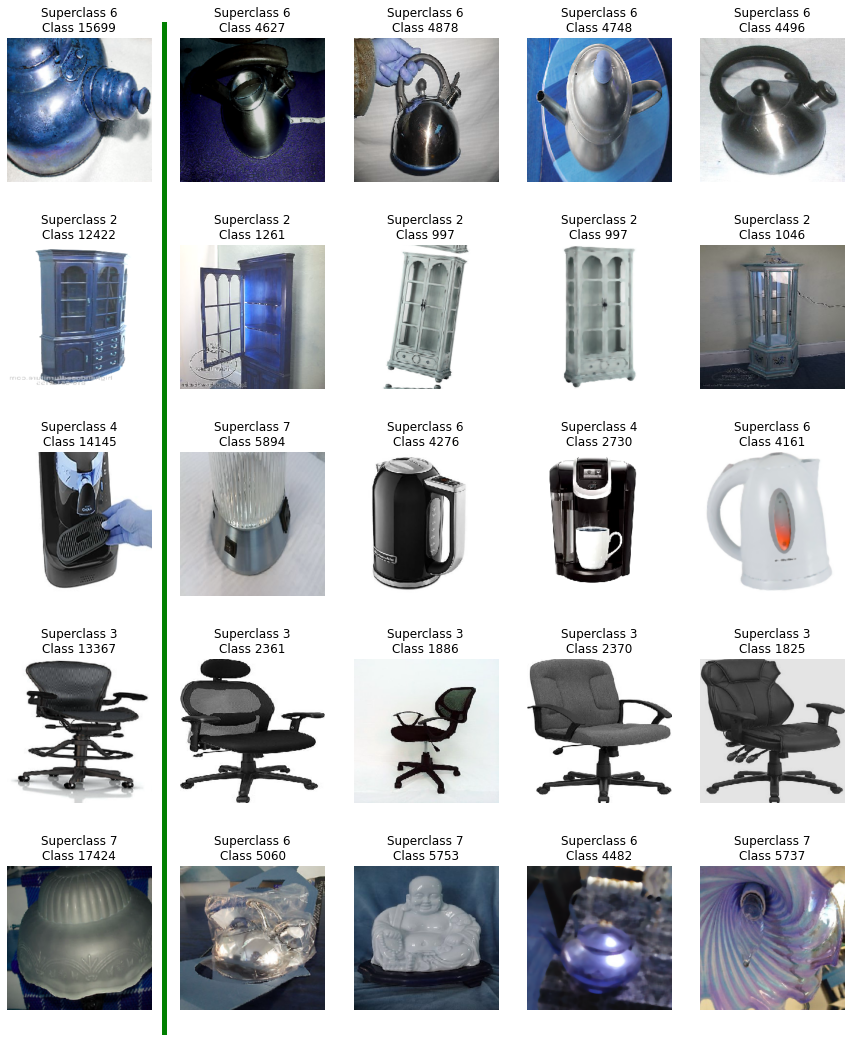

In [21]:
visualize_retrieval(resnet18)

# Fine-tune with vanilla Cross-Entropy and classification approach

We take the pretrained resnet model and add one Linear layer on top of it to classify between 12 superclasses.

In [22]:
num_ftrs = resnet18.fc.in_features

resnet18.fc = nn.Linear(num_ftrs, 12)

resnet18_finetuned = resnet18.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(resnet18_finetuned.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [23]:
data_loaders = {
    'train': torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(valid_dataset, batch_size=4, shuffle=True, num_workers=4)
}

dataset_sizes = {
    'train': len(train_dataset),
    'val': len(valid_dataset),
}

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in tqdm(data_loaders[phase]):
                img, main_class_id, main_super_class_id = data[0], data[1], data[2]
                main_super_class_id -= 1
                
                try:
                    inputs = img.to(device)
                    labels = main_super_class_id.to(device)
                except:
                    print('Cannot move to device, skipping')
                    
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
resnet18_finetuned = train_model(resnet18_finetuned, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


100%|█| 11910/11910 [03:08<00:00, 63.29it/s


train Loss: 1.4236 Acc: 0.5533


100%|█| 2978/2978 [00:16<00:00, 185.46it/s]


val Loss: 1.0326 Acc: 0.6892

Epoch 1/24
----------


100%|█| 11910/11910 [02:42<00:00, 73.12it/s


train Loss: 1.1044 Acc: 0.6516


100%|█| 2978/2978 [00:16<00:00, 185.74it/s]


val Loss: 0.8624 Acc: 0.7226

Epoch 2/24
----------


100%|█| 11910/11910 [02:43<00:00, 72.85it/s


train Loss: 0.9620 Acc: 0.6948


100%|█| 2978/2978 [00:16<00:00, 185.31it/s]


val Loss: 0.8496 Acc: 0.7329

Epoch 3/24
----------


100%|█| 11910/11910 [02:41<00:00, 73.71it/s


train Loss: 0.8657 Acc: 0.7215


100%|█| 2978/2978 [00:15<00:00, 186.25it/s]


val Loss: 0.8222 Acc: 0.7509

Epoch 4/24
----------


100%|█| 11910/11910 [02:42<00:00, 73.23it/s


train Loss: 0.7804 Acc: 0.7488


100%|█| 2978/2978 [00:15<00:00, 188.34it/s]


val Loss: 0.7482 Acc: 0.7652

Epoch 5/24
----------


100%|█| 11910/11910 [02:41<00:00, 73.79it/s


train Loss: 0.7095 Acc: 0.7685


100%|█| 2978/2978 [00:16<00:00, 186.06it/s]


val Loss: 0.8257 Acc: 0.7459

Epoch 6/24
----------


100%|█| 11910/11910 [02:42<00:00, 73.10it/s


train Loss: 0.6515 Acc: 0.7880


100%|█| 2978/2978 [00:15<00:00, 187.30it/s]


val Loss: 0.7731 Acc: 0.7651

Epoch 7/24
----------


100%|█| 11910/11910 [02:42<00:00, 73.26it/s


train Loss: 0.4287 Acc: 0.8615


100%|█| 2978/2978 [00:15<00:00, 186.64it/s]


val Loss: 0.6476 Acc: 0.8066

Epoch 8/24
----------


100%|█| 11910/11910 [02:41<00:00, 73.56it/s


train Loss: 0.3590 Acc: 0.8846


100%|█| 2978/2978 [00:15<00:00, 188.32it/s]


val Loss: 0.6219 Acc: 0.8108

Epoch 9/24
----------


100%|█| 11910/11910 [02:42<00:00, 73.47it/s


train Loss: 0.3254 Acc: 0.8942


100%|█| 2978/2978 [00:15<00:00, 187.66it/s]


val Loss: 0.6397 Acc: 0.8103

Epoch 10/24
----------


100%|█| 11910/11910 [02:42<00:00, 73.18it/s


train Loss: 0.3045 Acc: 0.9025


100%|█| 2978/2978 [00:16<00:00, 183.30it/s]


val Loss: 0.6365 Acc: 0.8192

Epoch 11/24
----------


100%|█| 11910/11910 [02:42<00:00, 73.22it/s


train Loss: 0.2893 Acc: 0.9072


100%|█| 2978/2978 [00:16<00:00, 184.58it/s]


val Loss: 0.6463 Acc: 0.8137

Epoch 12/24
----------


100%|█| 11910/11910 [02:43<00:00, 72.79it/s


train Loss: 0.2670 Acc: 0.9162


100%|█| 2978/2978 [00:16<00:00, 186.03it/s]


val Loss: 0.6514 Acc: 0.8176

Epoch 13/24
----------


100%|█| 11910/11910 [02:43<00:00, 72.64it/s


train Loss: 0.2501 Acc: 0.9207


100%|█| 2978/2978 [00:16<00:00, 184.26it/s]


val Loss: 0.6451 Acc: 0.8169

Epoch 14/24
----------


100%|█| 11910/11910 [02:43<00:00, 72.98it/s


train Loss: 0.2259 Acc: 0.9297


100%|█| 2978/2978 [00:15<00:00, 187.75it/s]


val Loss: 0.6510 Acc: 0.8136

Epoch 15/24
----------


100%|█| 11910/11910 [02:43<00:00, 72.90it/s


train Loss: 0.2248 Acc: 0.9286


100%|█| 2978/2978 [00:16<00:00, 183.08it/s]


val Loss: 0.6304 Acc: 0.8150

Epoch 16/24
----------


100%|█| 11910/11910 [02:43<00:00, 72.86it/s


train Loss: 0.2248 Acc: 0.9297


100%|█| 2978/2978 [00:16<00:00, 185.95it/s]


val Loss: 0.6648 Acc: 0.8172

Epoch 17/24
----------


100%|█| 11910/11910 [02:43<00:00, 72.78it/s


train Loss: 0.2224 Acc: 0.9315


100%|█| 2978/2978 [00:16<00:00, 184.01it/s]


val Loss: 0.6480 Acc: 0.8150

Epoch 18/24
----------


100%|█| 11910/11910 [02:43<00:00, 72.87it/s


train Loss: 0.2142 Acc: 0.9326


100%|█| 2978/2978 [00:16<00:00, 184.18it/s]


val Loss: 0.6500 Acc: 0.8218

Epoch 19/24
----------


100%|█| 11910/11910 [02:44<00:00, 72.54it/s


train Loss: 0.2162 Acc: 0.9309


100%|█| 2978/2978 [00:15<00:00, 187.68it/s]


val Loss: 0.6481 Acc: 0.8208

Epoch 20/24
----------


100%|█| 11910/11910 [02:41<00:00, 73.72it/s


train Loss: 0.2091 Acc: 0.9340


100%|█| 2978/2978 [00:15<00:00, 188.51it/s]


val Loss: 0.6695 Acc: 0.8223

Epoch 21/24
----------


100%|█| 11910/11910 [02:41<00:00, 73.80it/s


train Loss: 0.2109 Acc: 0.9341


100%|█| 2978/2978 [00:15<00:00, 188.14it/s]


val Loss: 0.6422 Acc: 0.8193

Epoch 22/24
----------


100%|█| 11910/11910 [02:43<00:00, 72.64it/s


train Loss: 0.2091 Acc: 0.9342


100%|█| 2978/2978 [00:15<00:00, 187.24it/s]


val Loss: 0.6406 Acc: 0.8199

Epoch 23/24
----------


100%|█| 11910/11910 [02:42<00:00, 73.18it/s


train Loss: 0.2107 Acc: 0.9344


100%|█| 2978/2978 [00:16<00:00, 185.60it/s]


val Loss: 0.6501 Acc: 0.8195

Epoch 24/24
----------


100%|█| 11910/11910 [02:44<00:00, 72.61it/s


train Loss: 0.2095 Acc: 0.9339


100%|█| 2978/2978 [00:16<00:00, 184.25it/s]

val Loss: 0.6489 Acc: 0.8190

Training complete in 74m 58s
Best val Acc: 0.822349


During the training, the accucary has increased significantly and validation loss has decreased as well.

In [26]:
# Use the model object to select the desired layer
layer_finetuned = resnet18_finetuned._modules.get('avgpool')

# Set model to evaluation mode
resnet18_finetuned.eval()

checkpoint = {'state_dict': resnet18_finetuned.state_dict(), 'optimizer': optimizer_ft.state_dict()}
torch.save(checkpoint, 'finetuned-resnet-checkpoint.pth')

In [27]:
feature_v = get_vector(resnet18_finetuned, example)
feature_v.shape

torch.Size([512])

In [28]:
annoy_index = build_index(resnet18_finetuned, 'first-finetune-resnet18')
annoy_index.get_nns_by_item(0, 5)

100%|█| 47640/47640 [04:32<00:00, 174.90it/


Skipped 0 data points because of reading / transformation errors
Successfully saved 47640 data points in the index


[0, 45453, 19296, 3147, 34557]

In [29]:
evaluate(valid_dataset)

100%|█| 11911/11911 [03:31<00:00, 56.34it/s

Ranked Top-5 accuracy for Class ID: 0.04
Ranked Top-5 accuracy for Superclass ID: 0.79

mAP5 for Class ID: 0.03
mAP5 for Superclass ID: 0.76


### Top-5 Accuracy for Class ID is 4%, for Superclass ID it's 79%.
### mAP5 for Class ID is 3%, for Superclass ID it's 76%.

It's much better than the base version, considering the Superclass score. (the model has been finetuned on Superclass classification)

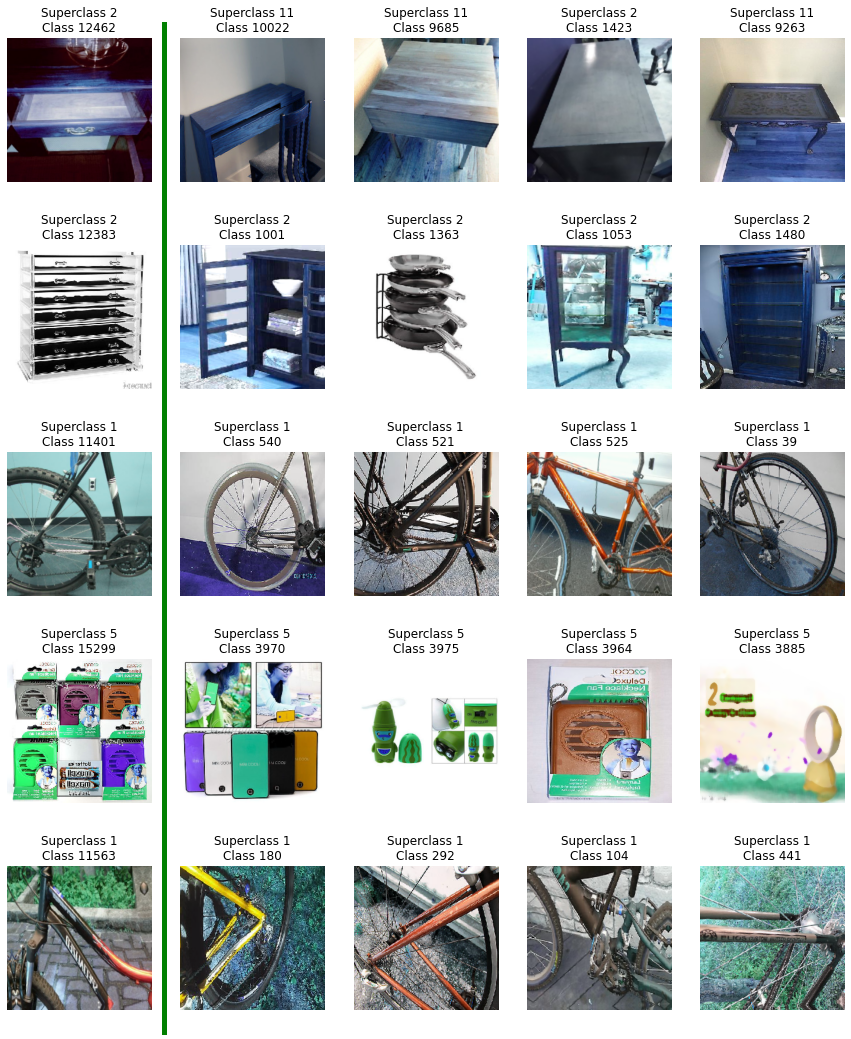

In [30]:
visualize_retrieval(resnet18_finetuned)

# Please continue to Part 2 to see Metric Learning results and Conclusions.